# Introduction

The client is a leader in innovative computer vision solutions, and is seeking help to develop MonReader, a new mobile document digitization experience for the blind, researchers, and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. MonReader is a mobile app that detects page flips from low-resolution camera preview, takes a high-resolution picture of the document, recognizing its corners, and crops it accordingly; it dewarps the cropped document to obtain a bird's eye view, and sharpens the contrast between the text and the background; and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.

The dataset consists of frames extracted from page flipping videos from smart phones, which were eventually labelled as flipping and not flipping. The frame names are stored in the `data/raw` folder in sequential order with the following naming structure: `VideoID_FrameNumber`.

The goal of the project is to build a deep learning model that is able to predict:

1. if the page is being flipped using a single image;
2. if a given sequence of images contains an action of flipping.

Evaluation will primarily base on the F1 score. The main goals are: 

1. reach a F1-score of 91% (or higher)
2. build a model that is smaller than 40 MB.

# Libraries

In [1]:
# basics
import numpy as np 
import pandas as pd
import tensorflow as tf
import os

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# neural networks
from tensorflow.keras import layers
from tensorflow.keras import backend as bk
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

# pre-trained models
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet (50 layers)
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNet (version 2)
from tensorflow.keras.applications.efficientnet import EfficientNetB5 #EfficientNet

# metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


2024-04-30 15:32:30.993043: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data exploration

In [2]:
train_data_dir = '../data/raw/images/training'
test_data_dir = '../data/raw/images/testing'
img_height, img_width, img_chn = 200, 200, 3
batch_size = 16

train_imgs = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir, 
  validation_split=0.15,
  subset='training',
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
)

val_imgs= tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.15,
  subset='validation',
  seed=42, 
  image_size=(img_height, img_width),
  batch_size=batch_size
)

test_imgs = tf.keras.preprocessing.image_dataset_from_directory(
  test_data_dir,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 2392 files belonging to 2 classes.
Using 2034 files for training.
Found 2392 files belonging to 2 classes.
Using 358 files for validation.
Found 597 files belonging to 2 classes.


Before taking a look at the data, I first split it into train, validation, and test subsets. Notice that the function and batching. Moreover, it also automatically identifies the classes associated to each image.

In [3]:
classes = train_imgs.class_names
classes

['flip', 'notflip']

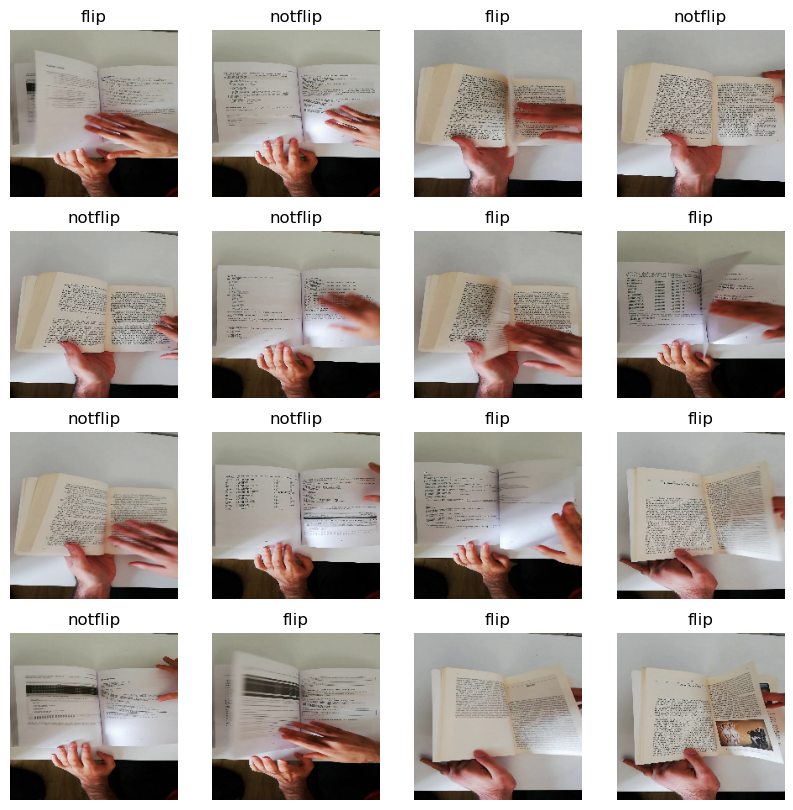

In [4]:
plt.figure(figsize=(10,10))

for images, labels in train_imgs.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

plt.show()

I will now turn to build a series of neural network models that may be able to predict the class of each image, possibly with different degrees of accuracy. In particular, I will:

1. build a convolutional neural network (CNN) from scrach
2. implement transfer learning from four existing models:
      * VGG-16
      * RestNet
      * MobileNet
      * EfficientNet

# Modeling

## Custom CNN

My CNN model from scratch is a standard CNN model with: 

1. 2 convolutional layers, each with a 3x3 filter, with
2. 2 max pooling layers inbetween the two convolutional layers; and 
3. 2 fully connected dense layers, which feed
4. the output softmax layer

In [5]:
cnn = Sequential([
  # conv layer 1
  layers.Conv2D(
    filters=16,
    kernel_size=(3,3),
    activation='relu',
    input_shape=(img_width, img_height, img_chn),
  ),

  # max pooling layer 1
  layers.MaxPooling2D((2,2)),

  #conv layer 2
  layers.Conv2D(
    filters=32,
    kernel_size=(3,3),
    activation='relu'
  ),

  # max pooling layer 2
  layers.MaxPooling2D((2,2)),

  # flattening the layers in a single dimension
  layers.Flatten(),

  # fully connected/dense layer 1
  layers.Dense(64, activation='relu'),

  # fully connected/dense layer 2
  layers.Dense(128, activation='relu'),

  # softmax output layer
  layers.Dense(len(classes), activation='softmax')
], 
name='custom-CNN'
)

In [6]:
def recall_m(y_true, y_pred):
  tp = bk.sum(bk.round(bk.clip(y_true*y_pred, 0, 1)))
  actual_positives = bk.sum(bk.round(bk.clip(y_true, 0, 1)))
  recall = tp/(actual_positives + bk.epsilon())
  return recall

def precision_m(y_true, y_pred):
  tp = bk.sum(bk.round(bk.clip(y_true*y_pred, 0, 1)))
  predicted_positives = bk.sum(bk.round(bk.clip(y_pred, 0, 1)))
  precision = tp/(predicted_positives + bk.epsilon())
  return precision

def f1score_m(y_true, y_pred):
  recall = recall_m(y_true, y_pred)
  precision = precision_m(y_true, y_pred)
  f1score = 2*((precision*recall)/(precision+recall+bk.epsilon()))
  return f1score

cnn.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy', recall_m, precision_m, f1score_m]
)

### Training

In [7]:
cnn_training = cnn.fit(
  train_imgs,
  validation_data=val_imgs,
  epochs=10
)

Epoch 1/10


128/128 [==============================] - 25s 184ms/step - loss: 18.8332 - accuracy: 0.7030 - recall_m: 1.0000 - precision_m: 0.5122 - f1score_m: 0.6677 - val_loss: 0.3708 - val_accuracy: 0.8436 - val_recall_m: 1.0000 - val_precision_m: 0.5290 - val_f1score_m: 0.6865
Epoch 2/10
128/128 [==============================] - 24s 186ms/step - loss: 0.2246 - accuracy: 0.9233 - recall_m: 1.0000 - precision_m: 0.5122 - f1score_m: 0.6684 - val_loss: 0.2966 - val_accuracy: 0.8855 - val_recall_m: 1.0000 - val_precision_m: 0.5290 - val_f1score_m: 0.6852
Epoch 3/10
128/128 [==============================] - 24s 188ms/step - loss: 0.1108 - accuracy: 0.9651 - recall_m: 0.9922 - precision_m: 0.5088 - f1score_m: 0.6640 - val_loss: 0.1939 - val_accuracy: 0.9134 - val_recall_m: 1.0000 - val_precision_m: 0.5245 - val_f1score_m: 0.6789
Epoch 4/10
128/128 [==============================] - 25s 193ms/step - loss: 0.0974 - accuracy: 0.9720 - recall_m: 1.0000 - precision_m: 0.5122 - f1score_m: 0.6679 - val_los

### Evaluation

#### Validation set

To evaluate the model with the validation set, I will use loss and accuracy built-in function; and manually calculate recall, precision, and f1-scores.

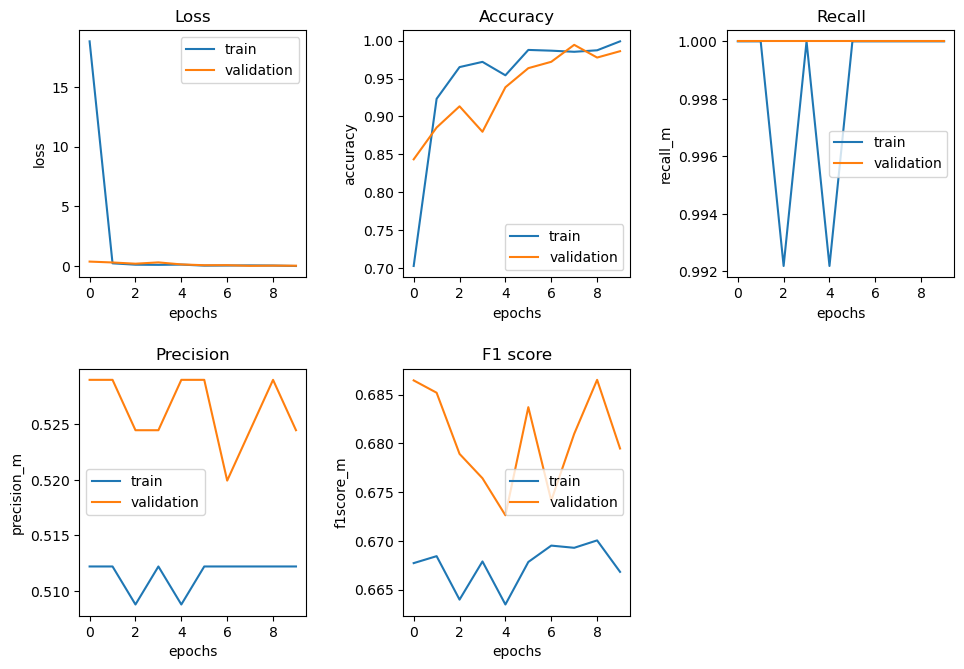

In [8]:
sets = ['train', 'validation']
metrics = ['loss', 'accuracy', 'recall_m', 'precision_m', 'f1score_m']
metrics_title = ['Loss', 'Accuracy', 'Recall', 'Precision', 'F1 score']

plt.figure(figsize=(10,10))
for m in range(len(metrics)):
  ax = plt.subplot(3,3, m+1)
  plt.plot(cnn_training.history[metrics[m]])
  plt.plot(cnn_training.history['val_'+metrics[m]])
  plt.title(metrics_title[m])
  plt.ylabel(metrics[m])
  plt.xlabel('epochs')
  plt.legend(['train', 'validation'])

plt.tight_layout(pad=2.0)
plt.show()

#### Test set

Here, I finally take a look at the performance of the model with the actual test data. 

In [9]:
def evaluate_model(model, test_data):
  eval_metrics = {}

  predicted_labels = []
  true_labels = []
  
  for images, labels in test_data:
    true_labels.extend(labels.numpy())
    predicted_labels.extend(tf.argmax(model.predict(images), axis=1).numpy())

  eval_metrics['accuracy'] = accuracy_score(true_labels, predicted_labels)
  eval_metrics['f1_score'] = f1_score(true_labels, predicted_labels)
  eval_metrics = pd.Series(eval_metrics)
  confusion_m = confusion_matrix(true_labels, predicted_labels)

  plt.figure(figsize=(10,10))
  sns.heatmap(confusion_m, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
  plt.xlabel('predicted labels')
  plt.ylabel('actual labels')
  plt.title('confusion matrix')
  plt.show()

  print(eval_metrics)
  return eval_metrics


1/1 [==============================] - 0s 39ms/step


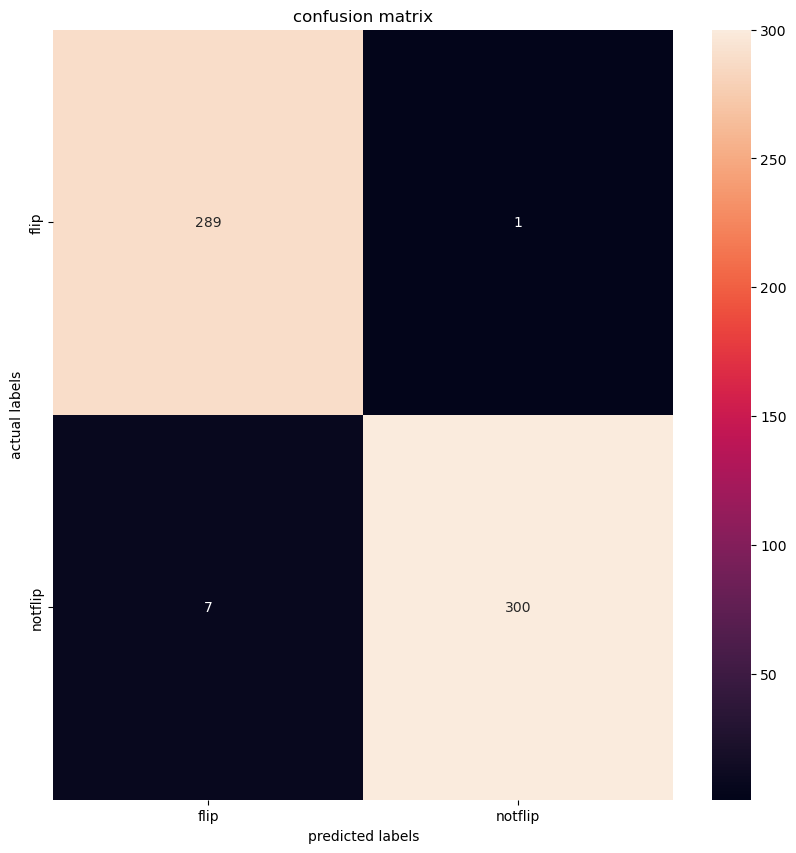

accuracy    0.986600
f1_score    0.986842
dtype: float64


In [10]:
cnn_evaluation = evaluate_model(cnn, test_imgs)

### Custom CNN -- conclusions

The model reaches the remarkable accuracy and F1 scores of ~99%, which is 8 points higher than the goal of the project. However the model has a size that is 10 MB larger than our goal (see below). In theory, one should be able to reduce the size of the model by reducing the number of units in each layer.

In [11]:
save_dir = '../src/models/'
cnn_save_dir = save_dir + 'cnn.keras'
cnn.save(cnn_save_dir)

sizes = {'cnn': os.path.getsize(cnn_save_dir) / (1024*1024)}

print(f"CNN model size: {sizes['cnn']:.2f} MB")

CNN model size: 54.21 MB


## VGG-16

In [12]:
def vgg_transfer(train_imgs, val_imgs, img_width, img_height, img_chn, classes):
    # load the model
    vgg16 = VGG16(
      weights='imagenet', # fetching the pretrained hyperparameters
      input_shape = (img_width, img_height, img_chn),
      classes = classes,
      include_top=False,
      pooling='avg'
    )
    
    # freeze the weights of the remaining layers so they are not retrained during the training process
    for layer in vgg16.layers:
      layer.trainable=False

    last_layer = vgg16.layers[-1].output # remove the last layer of the pre-trained model
    last_layer = layers.Flatten()(last_layer) # flatten it
    last_layer = layers.Dense(256, activation='relu')(last_layer) # add a new hidden layer
    last_layer = layers.Dropout(0.5)(last_layer) # to avoid overfitting
    output_layer = layers.Dense(classes, activation='softmax')(last_layer)

    vgg_model = Model(inputs=vgg16.input, outputs=output_layer)
    vgg_model.compile(
      optimizer = 'adam',
      loss = 'sparse_categorical_crossentropy',
      metrics = ['accuracy', recall_m, precision_m, f1score_m]
      )
    
    trained_vgg16 = vgg_model.fit(
       train_imgs,
       epochs=10,
       validation_data=val_imgs
    )

    return vgg_model, trained_vgg16


### Training

In [13]:
vgg_model, trained_vgg16 = vgg_transfer(train_imgs, val_imgs, img_width, img_height, img_chn, len(classes))

Epoch 1/10
128/128 [==============================] - 155s 1s/step - loss: 0.9211 - accuracy: 0.7807 - recall_m: 1.0000 - precision_m: 0.5122 - f1score_m: 0.6692 - val_loss: 0.1733 - val_accuracy: 0.9218 - val_recall_m: 1.0000 - val_precision_m: 0.5154 - val_f1score_m: 0.6664
Epoch 2/10
128/128 [==============================] - 159s 1s/step - loss: 0.2246 - accuracy: 0.9130 - recall_m: 1.0000 - precision_m: 0.5122 - f1score_m: 0.6675 - val_loss: 0.0888 - val_accuracy: 0.9637 - val_recall_m: 1.0000 - val_precision_m: 0.5245 - val_f1score_m: 0.6803
Epoch 3/10
128/128 [==============================] - 158s 1s/step - loss: 0.1368 - accuracy: 0.9479 - recall_m: 1.0000 - precision_m: 0.5122 - f1score_m: 0.6714 - val_loss: 0.0639 - val_accuracy: 0.9749 - val_recall_m: 1.0000 - val_precision_m: 0.5245 - val_f1score_m: 0.6782
Epoch 4/10
128/128 [==============================] - 160s 1s/step - loss: 0.0964 - accuracy: 0.9666 - recall_m: 1.0000 - precision_m: 0.5122 - f1score_m: 0.6693 - val_l

### Evaluation

#### Validation set

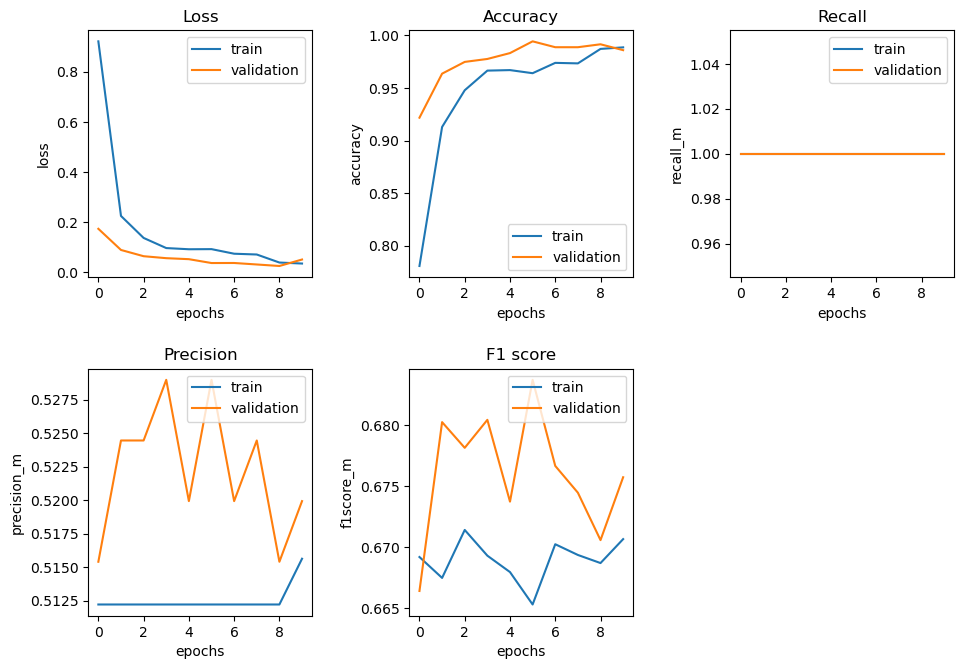

In [14]:
sets = ['train', 'validation']
metrics = ['loss', 'accuracy', 'recall_m', 'precision_m', 'f1score_m']
metrics_title = ['Loss', 'Accuracy', 'Recall', 'Precision', 'F1 score']

plt.figure(figsize=(10,10))
for m in range(len(metrics)):
  ax = plt.subplot(3,3, m+1)
  plt.plot(trained_vgg16.history[metrics[m]])
  plt.plot(trained_vgg16.history['val_'+metrics[m]])
  plt.title(metrics_title[m])
  plt.ylabel(metrics[m])
  plt.xlabel('epochs')
  plt.legend(['train', 'validation'])

plt.tight_layout(pad=2.0)
plt.show()

#### Test set

1/1 [==============================] - 0s 372ms/step


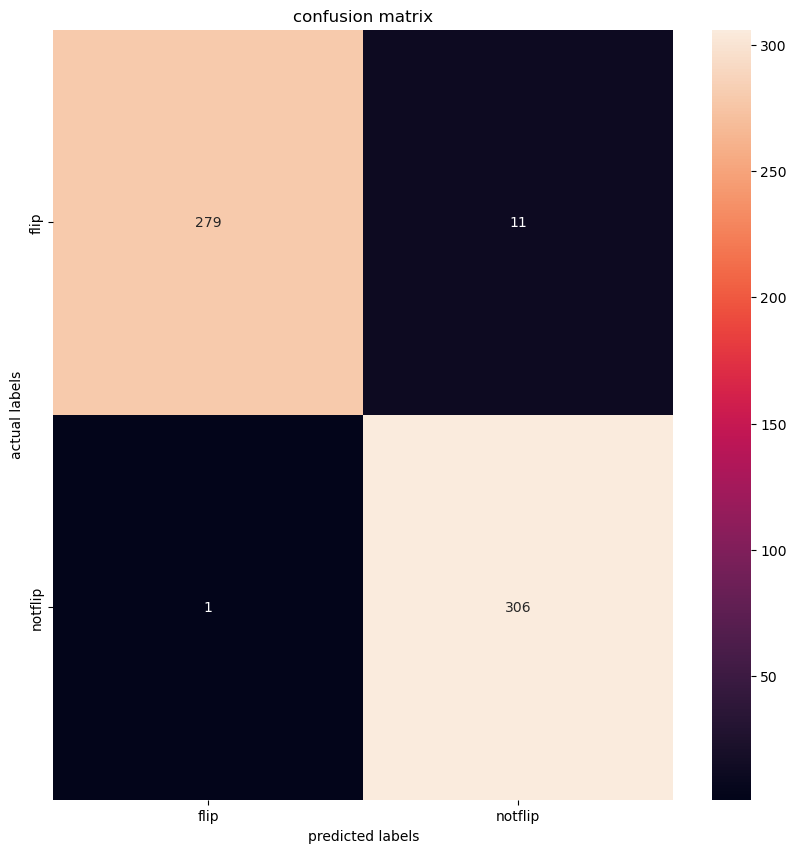

accuracy    0.979899
f1_score    0.980769
dtype: float64


In [15]:
vgg_evaluation = evaluate_model(vgg_model, test_imgs)

### VGG16 -- Interim conclusion

The model reaches the remarkable accuracy and F1 scores of ~98%, which is 7 points higher than the goal of the project. However the model has a size that is about 18 MB larger than our goal (see below). In theory, one should be able to reduce the size of the model by reducing the number of units in each layer, but this may impinge on level performance.

In [16]:
vgg_save_dir = save_dir + 'vgg16.keras'
vgg_model.save(vgg_save_dir)

sizes['vgg'] = os.path.getsize(vgg_save_dir) / (1024*1024)

print(f"VGG16 model size: {sizes['vgg']:.2f} MB")

VGG16 model size: 57.73 MB


## ResNet

In [17]:
def resnet_transfer(train_imgs, val_imgs, img_width, img_height, img_chn, classes):
    # load the model
    resnet = ResNet50(
      weights='imagenet', # fetching the pretrained hyperparameters
      input_shape = (img_width, img_height, img_chn),
      classes = classes,
      include_top=False,
      pooling='avg'
    )
    
    # freeze the weights of the remaining layers so they are not retrained during the training process
    for layer in resnet.layers:
      layer.trainable=False

    last_layer = resnet.layers[-1].output # remove the last layer of the pre-trained model
    last_layer = layers.Flatten()(last_layer) # flatten it
    last_layer = layers.Dense(256, activation='relu')(last_layer) # add a new hidden layer
    last_layer = layers.Dropout(0.5)(last_layer) # to avoid overfitting
    output_layer = layers.Dense(classes, activation='softmax')(last_layer)

    resnet_model = Model(inputs=resnet.input, outputs=output_layer)
    resnet_model.compile(
      optimizer = 'adam',
      loss = 'sparse_categorical_crossentropy',
      metrics = ['accuracy', recall_m, precision_m, f1score_m]
      )
    
    trained_resnet = resnet_model.fit(
       train_imgs,
       epochs=10,
       validation_data=val_imgs
    )

    return resnet_model, trained_resnet


### Training

In [18]:
resnet_model, trained_resnet = resnet_transfer(train_imgs, val_imgs, img_width, img_height, img_chn, len(classes))

Epoch 1/10
128/128 [==============================] - 116s 879ms/step - loss: 0.5048 - accuracy: 0.7955 - recall_m: 1.0000 - precision_m: 0.5156 - f1score_m: 0.6706 - val_loss: 0.2272 - val_accuracy: 0.9162 - val_recall_m: 1.0000 - val_precision_m: 0.5199 - val_f1score_m: 0.6698
Epoch 2/10
128/128 [==============================] - 100s 776ms/step - loss: 0.2029 - accuracy: 0.9154 - recall_m: 0.9922 - precision_m: 0.5088 - f1score_m: 0.6650 - val_loss: 0.1346 - val_accuracy: 0.9525 - val_recall_m: 1.0000 - val_precision_m: 0.5154 - val_f1score_m: 0.6685
Epoch 3/10
128/128 [==============================] - 99s 772ms/step - loss: 0.1498 - accuracy: 0.9469 - recall_m: 1.0000 - precision_m: 0.5156 - f1score_m: 0.6718 - val_loss: 0.1019 - val_accuracy: 0.9721 - val_recall_m: 1.0000 - val_precision_m: 0.5199 - val_f1score_m: 0.6753
Epoch 4/10
128/128 [==============================] - 103s 805ms/step - loss: 0.1444 - accuracy: 0.9449 - recall_m: 1.0000 - precision_m: 0.5122 - f1score_m: 0.6

### Evaluation

#### Validation set

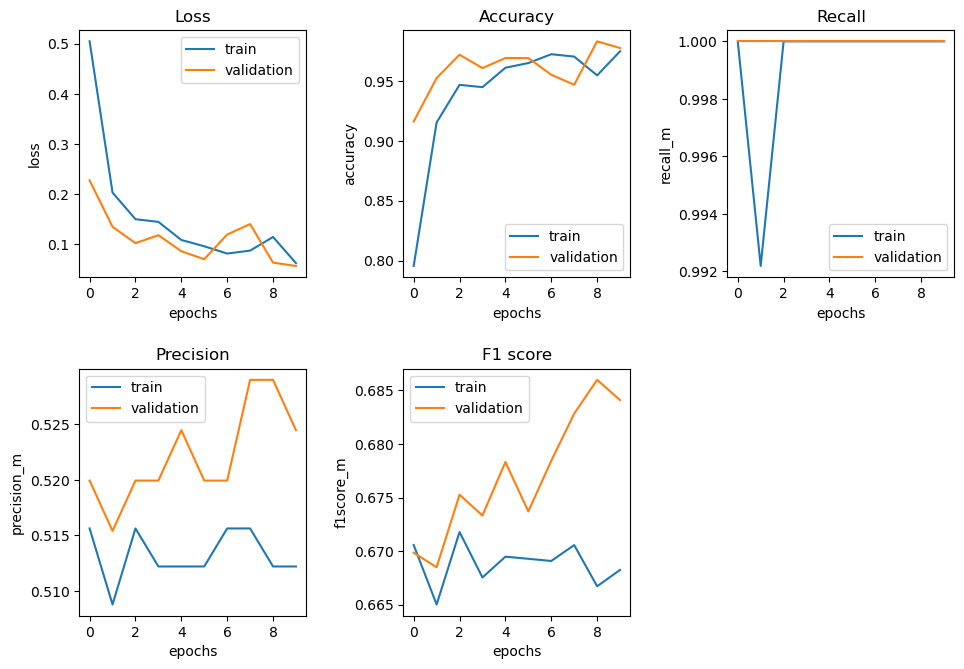

In [19]:
plt.figure(figsize=(10,10))
for m in range(len(metrics)):
  ax = plt.subplot(3,3, m+1)
  plt.plot(trained_resnet.history[metrics[m]])
  plt.plot(trained_resnet.history['val_'+metrics[m]])
  plt.title(metrics_title[m])
  plt.ylabel(metrics[m])
  plt.xlabel('epochs')
  plt.legend(['train', 'validation'])

plt.tight_layout(pad=2.0)
plt.show()

#### Test set

1/1 [==============================] - 0s 330ms/step


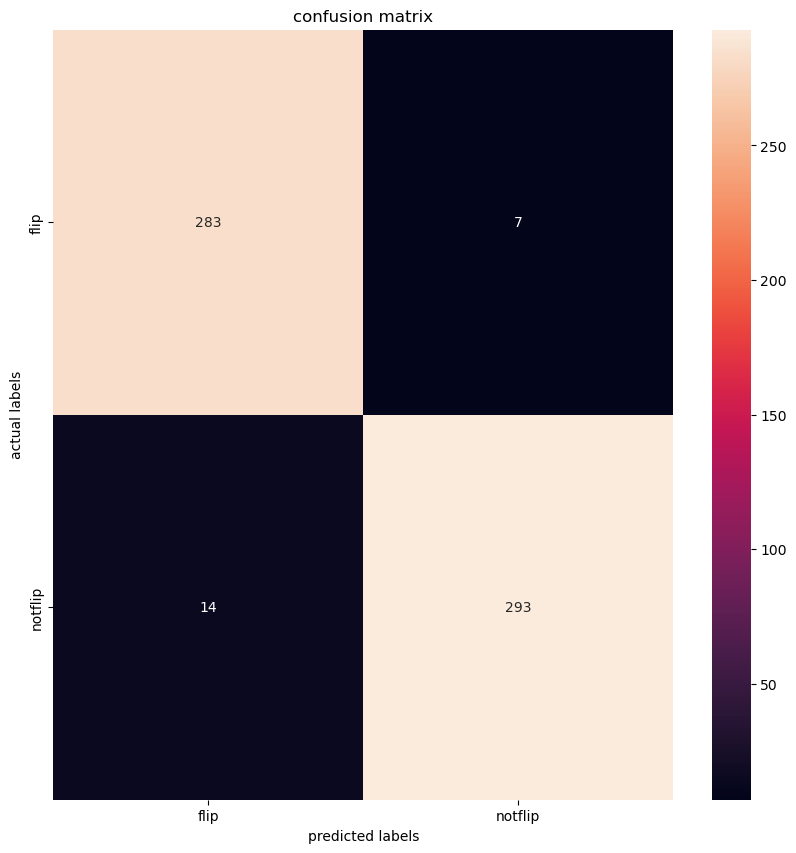

accuracy    0.964824
f1_score    0.965404
dtype: float64


In [20]:
resnet_evaluation = evaluate_model(resnet_model, test_imgs)

### ResNet -- Interim conclusion

The model reaches the remarkable accuracy and F1 scores of ~97%, which is 6 points higher than the goal of the project. However the model has a size that is around 56 MB larger than our goal. In theory, one should be able to reduce the size of the model by reducing the number of units in each layer, but it may impinge on model performance.



In [21]:
resnet_save_dir = save_dir + 'resnet.keras'
resnet_model.save(resnet_save_dir)

sizes['resnet'] = os.path.getsize(resnet_save_dir) / (1024*1024)

print(f"Resnet model size: {sizes['resnet']:.2f} MB")

Resnet model size: 96.56 MB


## MobileNet

In [22]:
def mobilenet_transfer(train_imgs, val_imgs, img_width, img_height, img_chn, classes):
    # load the model
    mobilenet = MobileNetV2(
      weights='imagenet', # fetching the pretrained hyperparameters
      input_shape = (img_width, img_height, img_chn),
      classes = classes,
      include_top=False,
      pooling='avg'
    )
    
    # freeze the weights of the remaining layers so they are not retrained during the training process
    for layer in mobilenet.layers:
      layer.trainable=False

    last_layer = mobilenet.layers[-1].output # remove the last layer of the pre-trained model
    last_layer = layers.Flatten()(last_layer) # flatten it
    last_layer = layers.Dense(256, activation='relu')(last_layer) # add a new hidden layer
    last_layer = layers.Dropout(0.5)(last_layer) # to avoid overfitting
    output_layer = layers.Dense(classes, activation='softmax')(last_layer)

    mobilenet_model = Model(inputs=mobilenet.input, outputs=output_layer)
    mobilenet_model.compile(
      optimizer = 'adam',
      loss = 'sparse_categorical_crossentropy',
      metrics = ['accuracy', recall_m, precision_m, f1score_m]
      )
    
    trained_mobilenet = mobilenet_model.fit(
       train_imgs,
       epochs=10,
       validation_data=val_imgs
    )

    return mobilenet_model, trained_mobilenet


### Training

In [23]:
mobilenet_model, trained_mobilenet = mobilenet_transfer(train_imgs, val_imgs, img_width, img_height, img_chn, len(classes))

Epoch 1/10
128/128 [==============================] - 45s 325ms/step - loss: 0.6342 - accuracy: 0.6804 - recall_m: 1.0000 - precision_m: 0.5122 - f1score_m: 0.6691 - val_loss: 0.4167 - val_accuracy: 0.8324 - val_recall_m: 1.0000 - val_precision_m: 0.5245 - val_f1score_m: 0.6810
Epoch 2/10
128/128 [==============================] - 40s 313ms/step - loss: 0.3971 - accuracy: 0.8250 - recall_m: 1.0000 - precision_m: 0.5122 - f1score_m: 0.6679 - val_loss: 0.3130 - val_accuracy: 0.8659 - val_recall_m: 1.0000 - val_precision_m: 0.5290 - val_f1score_m: 0.6864
Epoch 3/10
128/128 [==============================] - 39s 304ms/step - loss: 0.3573 - accuracy: 0.8422 - recall_m: 1.0000 - precision_m: 0.5156 - f1score_m: 0.6699 - val_loss: 0.2495 - val_accuracy: 0.9134 - val_recall_m: 1.0000 - val_precision_m: 0.5199 - val_f1score_m: 0.6722
Epoch 4/10
128/128 [==============================] - 37s 283ms/step - loss: 0.2585 - accuracy: 0.8928 - recall_m: 0.9922 - precision_m: 0.5088 - f1score_m: 0.6631

### Evaluation

#### Validation set

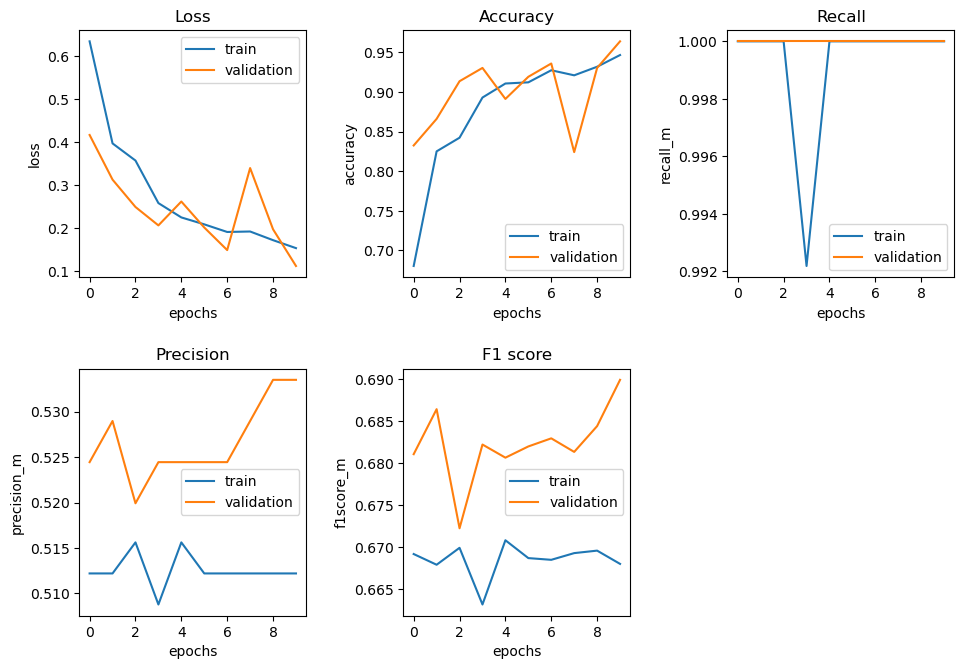

In [24]:
plt.figure(figsize=(10,10))
for m in range(len(metrics)):
  ax = plt.subplot(3,3, m+1)
  plt.plot(trained_mobilenet.history[metrics[m]])
  plt.plot(trained_mobilenet.history['val_'+metrics[m]])
  plt.title(metrics_title[m])
  plt.ylabel(metrics[m])
  plt.xlabel('epochs')
  plt.legend(['train', 'validation'])

plt.tight_layout(pad=2.0)
plt.show()

#### Test set

1/1 [==============================] - 0s 143ms/step


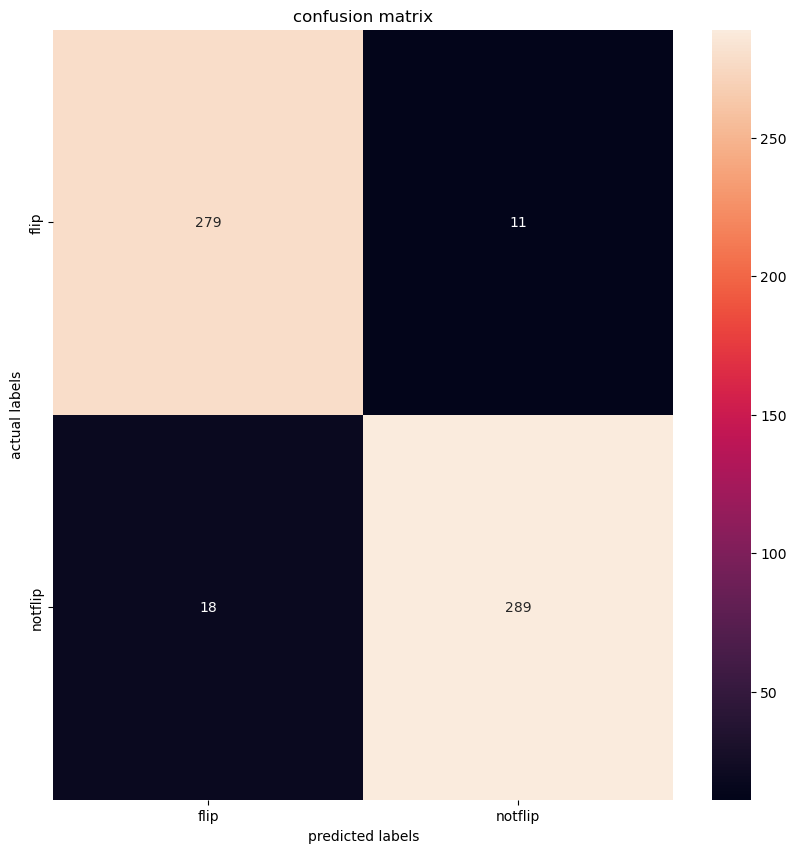

accuracy    0.951424
f1_score    0.952224
dtype: float64


In [25]:
mobilenet_evaluation = evaluate_model(mobilenet_model, test_imgs)

### MobileNet -- Interim conclusion
The model reaches the remarkable accuracy and F1 scores of ~95%, which is 4 points higher than the goal of the project. Although these results are a bit lower than the results of the previous models, the MobileNet remarkably reaches comparable accuracy scores, while having a very small size (27 MB smaller than the goal size).

In [26]:
mobilenet_save_dir = save_dir + 'mobilenet.keras'
mobilenet_model.save(mobilenet_save_dir)

sizes['mobilenet'] = os.path.getsize(mobilenet_save_dir) / (1024*1024)

print(f"MobileNet model size: {sizes['mobilenet']:.2f} MB")

MobileNet model size: 12.89 MB


## EfficientNet

In [27]:
def effnet_transfer(train_imgs, val_imgs, img_width, img_height, img_chn, classes):
    # load the model
    effnet = EfficientNetB5(
      weights='imagenet', # fetching the pretrained hyperparameters
      input_shape = (img_width, img_height, img_chn),
      classes = classes,
      include_top=False,
      pooling='avg'
    )
    
    # freeze the weights of the remaining layers so they are not retrained during the training process
    for layer in effnet.layers:
      layer.trainable=False

    last_layer = effnet.layers[-1].output # remove the last layer of the pre-trained model
    last_layer = layers.Flatten()(last_layer) # flatten it
    last_layer = layers.Dense(256, activation='relu')(last_layer) # add a new hidden layer
    last_layer = layers.Dropout(0.5)(last_layer) # to avoid overfitting
    output_layer = layers.Dense(classes, activation='softmax')(last_layer)

    effnet_model = Model(inputs=effnet.input, outputs=output_layer)
    effnet_model.compile(
      optimizer = 'adam',
      loss = 'sparse_categorical_crossentropy',
      metrics = ['accuracy', recall_m, precision_m, f1score_m]
      )
    
    trained_effnet = effnet_model.fit(
       train_imgs,
       epochs=10,
       validation_data=val_imgs
    )

    return effnet_model, trained_effnet


### Training

In [28]:
effnet_model, trained_effnet = effnet_transfer(train_imgs, val_imgs, img_width, img_height, img_chn, len(classes))

Epoch 1/10
128/128 [==============================] - 217s 2s/step - loss: 0.3691 - accuracy: 0.8235 - recall_m: 1.0000 - precision_m: 0.5156 - f1score_m: 0.6717 - val_loss: 0.2244 - val_accuracy: 0.9050 - val_recall_m: 1.0000 - val_precision_m: 0.5290 - val_f1score_m: 0.6845
Epoch 2/10
128/128 [==============================] - 204s 2s/step - loss: 0.2332 - accuracy: 0.9041 - recall_m: 1.0000 - precision_m: 0.5122 - f1score_m: 0.6692 - val_loss: 0.1456 - val_accuracy: 0.9525 - val_recall_m: 1.0000 - val_precision_m: 0.5290 - val_f1score_m: 0.6864
Epoch 3/10
128/128 [==============================] - 199s 2s/step - loss: 0.1975 - accuracy: 0.9208 - recall_m: 1.0000 - precision_m: 0.5156 - f1score_m: 0.6697 - val_loss: 0.1191 - val_accuracy: 0.9693 - val_recall_m: 1.0000 - val_precision_m: 0.5154 - val_f1score_m: 0.6717
Epoch 4/10
128/128 [==============================] - 199s 2s/step - loss: 0.1653 - accuracy: 0.9351 - recall_m: 1.0000 - precision_m: 0.5122 - f1score_m: 0.6694 - val_l

### Evaluation

#### Validation set

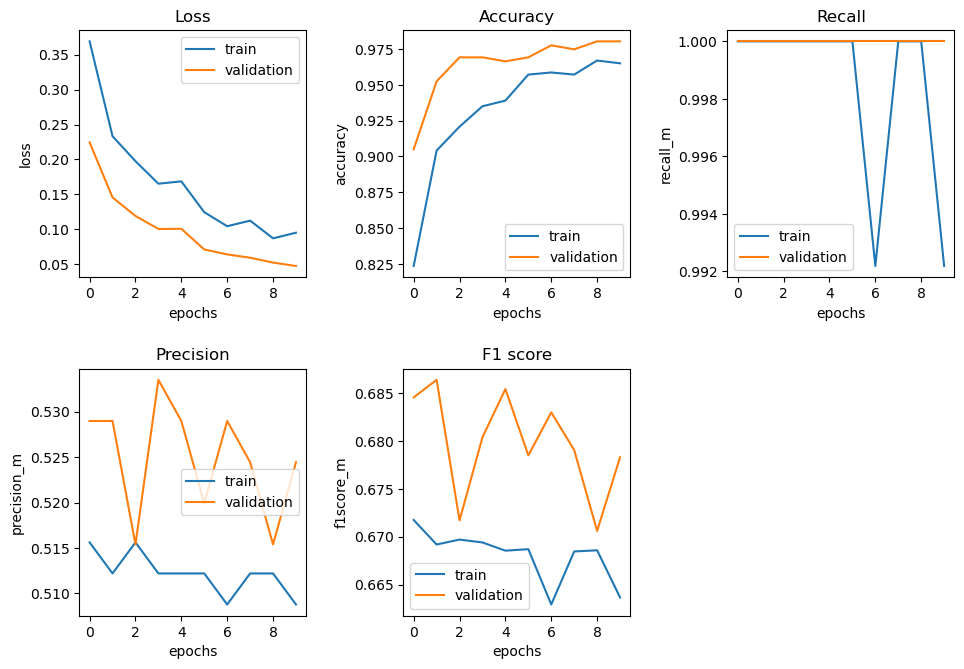

In [29]:
plt.figure(figsize=(10,10))
for m in range(len(metrics)):
  ax = plt.subplot(3,3, m+1)
  plt.plot(trained_effnet.history[metrics[m]])
  plt.plot(trained_effnet.history['val_'+metrics[m]])
  plt.title(metrics_title[m])
  plt.ylabel(metrics[m])
  plt.xlabel('epochs')
  plt.legend(['train', 'validation'])

plt.tight_layout(pad=2.0)
plt.show()

#### Test set

1/1 [==============================] - 1s 574ms/step


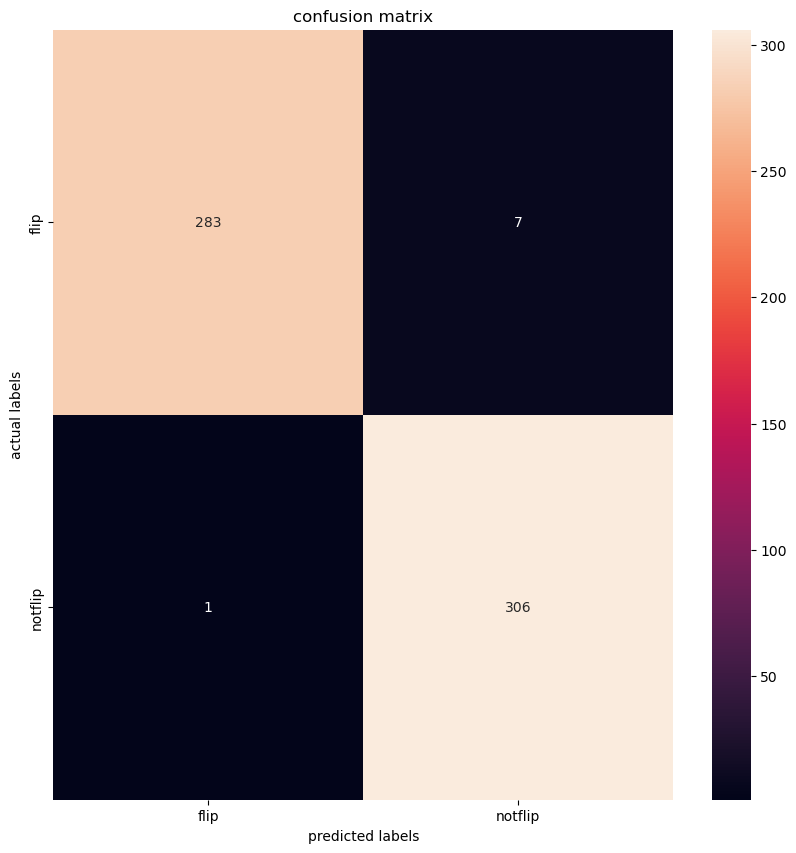

accuracy    0.986600
f1_score    0.987097
dtype: float64


In [30]:
effnet_evaluation = evaluate_model(effnet_model, test_imgs)

### EfficientNet -- Interim conclusion
The model reaches the remarkable accuracy and F1 scores of ~99%, which is 8 points higher than the goal of the project. However the model has a size that is about 76 MB larger than our goal (see below). In theory, one should be able to reduce the size of the model by reducing the number of units in each layer, but this may impinge on model performance.


In [31]:
effnet_save_dir = save_dir + 'efficientnet.keras'
effnet_model.save(effnet_save_dir)

sizes['efficientnet'] = os.path.getsize(effnet_save_dir) / (1024*1024)

print(f"EfficientNet model size: {sizes['efficientnet']:.2f} MB")

EfficientNet model size: 116.48 MB


# Conclusions

In this notebook, I went though a series of CNN models to help the mobile app Monreader classify images showing and not showing page flips. All models (custom CNN, VGG16, ResNet, MobileNet, and EfficientNet) performed very well, but only the MobileMobile model had a suitable size, while keeping high accuracy scores.

In [32]:
metrics_summary = {
  'accuracy': [
    cnn_evaluation['accuracy'],
    vgg_evaluation['accuracy'],
    resnet_evaluation['accuracy'],
    mobilenet_evaluation['accuracy'],
    effnet_evaluation['accuracy'],
  ],
  'f1-score': [
    cnn_evaluation['f1_score'],
    vgg_evaluation['f1_score'],
    resnet_evaluation['f1_score'],
    mobilenet_evaluation['f1_score'],
    effnet_evaluation['f1_score'],
  ],
  'size': list(sizes.values())
}

metrics_summary = pd.DataFrame(metrics_summary, index = ['Custom CNN', 'VGG16', 'ResNet', 'Mobilenet', 'EfficientNet'])
print(metrics_summary)

              accuracy  f1-score        size
Custom CNN    0.986600  0.986842   54.205174
VGG16         0.979899  0.980769   57.731837
ResNet        0.964824  0.965404   96.562760
Mobilenet     0.951424  0.952224   12.886937
EfficientNet  0.986600  0.987097  116.480263


### Gradio demo app

In [35]:
import gradio as gr
import random

# reiterating useful variables (defined above) for convenience
save_dir = '../src/models/'
classes = train_imgs.class_names

# creating a list of the images in the flip and not flip subdirectories of the test set
flip_dir = [test_data_dir + '/flip/' + file for file in os.listdir(test_data_dir + '/flip/')]
notflip_dir = [test_data_dir + '/notflip/' + file for file in os.listdir(test_data_dir + '/notflip/')]

# random sampling 5 images from each directory
n = 5
flip_sample = random.sample(flip_dir, n)
notflip_sample = random.sample(notflip_dir, n)
img_samples = flip_sample + notflip_sample

def classify_pages(img): 
  #load the MobileNet-transferred model built above
  model = tf.keras.models.load_model(save_dir + 'mobilenet.keras', compile=False)

  # reshape the raw image to be suitable for the model. 
  img = tf.convert_to_tensor(img)
  img = tf.image.resize(img, (img_height, img_width))
  img = tf.cast(img, tf.float32)
  img = tf.expand_dims(img, 0)
   
  prediction = model.predict(img).flatten()
  
  return {classes[i]: float(prediction[i]) for i in range(len(classes))}

gr.Interface(fn = classify_pages,
             title = "Flip/notflip classification model demo",
             description = "Select any of the images examples below and click Submit to find out how the model classified it (as flip or not flip page).",
             inputs = gr.Image(),
             outputs = gr.Label(num_top_classes=2),
             allow_flagging='never',
             examples = img_samples).launch(share=False)

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.
